# **Decision-Making Model for Flight Ticket Purchases**

## **Data Preprocessing**

In [57]:
# Loading necesarry libaries
import pandas as pd # For data manipulation
from datetime import datetime as dt # Date time conversion and other
import seaborn as sns # For data visualization
import matplotlib.pyplot as plt # For data visualization
import numpy as np # For calculations
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [58]:
# Loading the dataset
df = pd.read_csv("flight_data.csv")

df.info() # Gives us a summary of the dataframe e.g. how many entries, na-values and what the data types

df.head() # Shows us the first 5 rows of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Airline             2950 non-null   object
 1   Flight Number       2950 non-null   int64 
 2   Source City         2950 non-null   object
 3   Departure Time      2950 non-null   object
 4   Number of Stops     2950 non-null   int64 
 5   Arrival Time        2950 non-null   object
 6   Destination City    2950 non-null   object
 7   Duration (Minutes)  2950 non-null   int64 
 8   Price               2950 non-null   object
dtypes: int64(3), object(6)
memory usage: 207.6+ KB


,Airline,Flight Number,Source City,Departure Time,Number of Stops,Arrival Time,Destination City,Duration (Minutes),Price
0,Norse Atlantic Airways (UK),712,Los Angeles,2024-04-25T16:30:00,0,2024-04-26T10:55:00,London,625,$244
1,Virgin Atlantic,142,Los Angeles,2024-04-25T19:10:00,0,2024-04-26T13:30:00,London,620,$793
2,Virgin Atlantic,8,Los Angeles,2024-04-25T15:55:00,0,2024-04-26T10:15:00,London,620,$793
3,Delta,5925,Los Angeles,2024-04-25T19:10:00,0,2024-04-26T13:30:00,London,620,$793
4,Delta,5978,Los Angeles,2024-04-25T15:55:00,0,2024-04-26T10:15:00,London,620,$793


In [59]:
# After looking at the dataset it is decided to create 7 new columns. We want the Departure Date and Depature Time to be two seperate columns and the same goes 
# for Arrival. We also want to create a new column called "Search Date" which contains the date which data was extracted (searched for). At last we also want to
# create a column that calculates the days until departure. 

df['Search Date'] = '2024-04-25' # The date the API call was made

# We need to change it to a datetime object before being able to extract the time and date
df['Departure Time'] = pd.to_datetime(df['Departure Time'])
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'])

df['Departure Date'] = df['Departure Time'].dt.strftime('%Y-%m-%d') # Extracting the date from Departure Time
df['Arrival Date'] = df['Arrival Time'].dt.strftime('%Y-%m-%d') # Extracting the date from Arrival Time
df['Departure Time'] = df['Departure Time'].dt.strftime('%H:%M:%S') # Extracting the time from Departure Time 
df['Arrival Time'] = df['Arrival Time'].dt.strftime('%H:%M:%S') # Extracting the time from Arrival Time

# Converting to datetime objects in order to calculate days until departure
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['Search Date'] = pd.to_datetime(df['Search Date'])
df['Days Until Departure'] = (df['Departure Date'] - df['Search Date']).dt.days # Takes the difference between the Search Date and actual Departure Date. 


# We also want convert minutes to hours to simplify (rounding to two decimals)
df['Duration (Hours)'] = (df['Duration (Minutes)'] / 60).round(2)


# Furthermore, it is decided to drop the column Flight Number since this won't be relevant for further analysis. 
df = df.drop(['Flight Number','Duration (Minutes)', 'Source City', 'Destination City'], axis=1)


df.head()

,Airline,Departure Time,Number of Stops,Arrival Time,Price,Search Date,Departure Date,Arrival Date,Days Until Departure,Duration (Hours)
0,Norse Atlantic Airways (UK),16:30:00,0,10:55:00,$244,2024-04-25,2024-04-25,2024-04-26,0,10.42
1,Virgin Atlantic,19:10:00,0,13:30:00,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
2,Virgin Atlantic,15:55:00,0,10:15:00,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
3,Delta,19:10:00,0,13:30:00,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
4,Delta,15:55:00,0,10:15:00,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33


In [60]:
# Since there are many unique Departure Times and Arrival Times it is decided to convert it into a categorical variable with 5 levels. 
# The remaining date variables
df['Departure Time'] = pd.to_datetime(df['Departure Time'], format='%H:%M:%S').dt.time
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M:%S').dt.time
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'])

# We define a function that should categorize 'Departure Time' and 'Arrival Time' based on some intervals we have defined.
def categorize_time(time):
    if time >= pd.to_datetime("00:00").time() and time < pd.to_datetime("04:00").time():
        return 'Night'
    elif time >= pd.to_datetime("04:00").time() and time < pd.to_datetime("08:00").time():
        return 'Early Morning'
    elif time >= pd.to_datetime("08:00").time() and time < pd.to_datetime("12:00").time():
        return 'Morning'
    elif time >= pd.to_datetime("12:00").time() and time < pd.to_datetime("18:00").time():
        return 'Afternoon'
    elif time >= pd.to_datetime("18:00").time() and time < pd.to_datetime("00:00").time():
        return 'Evening'
    else: 
        return 'Evening'

# Applying the newly created function in order to convert the columns into categorical variable
df['Departure Time'] = df['Departure Time'].apply(categorize_time)
df['Arrival Time'] = df['Arrival Time'].apply(categorize_time)

# Changing the data type
df['Departure Time'] = df['Departure Time'].astype('category')
df['Arrival Time'] = df['Arrival Time'].astype('category')

df.head()

,Airline,Departure Time,Number of Stops,Arrival Time,Price,Search Date,Departure Date,Arrival Date,Days Until Departure,Duration (Hours)
0,Norse Atlantic Airways (UK),Afternoon,0,Morning,$244,2024-04-25,2024-04-25,2024-04-26,0,10.42
1,Virgin Atlantic,Evening,0,Afternoon,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
2,Virgin Atlantic,Afternoon,0,Morning,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
3,Delta,Evening,0,Afternoon,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
4,Delta,Afternoon,0,Morning,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33


In [61]:
# Extracting the month, day and weekday from Departure date in order to use it in further analysis
df['Departure Month'] = df['Departure Date'].dt.month
df['Departure Day'] = df['Departure Date'].dt.day
df['Departure Weekday'] = df['Departure Date'].dt.weekday

# Then we drop the original column
df.drop('Search Date', axis=1, inplace=True)
df.drop('Departure Date', axis=1, inplace=True)
df.drop('Arrival Date', axis=1, inplace=True)

In [62]:
df.head()

,Airline,Departure Time,Number of Stops,Arrival Time,Price,Days Until Departure,Duration (Hours),Departure Month,Departure Day,Departure Weekday
0,Norse Atlantic Airways (UK),Afternoon,0,Morning,$244,0,10.42,4,25,3
1,Virgin Atlantic,Evening,0,Afternoon,$793,0,10.33,4,25,3
2,Virgin Atlantic,Afternoon,0,Morning,$793,0,10.33,4,25,3
3,Delta,Evening,0,Afternoon,$793,0,10.33,4,25,3
4,Delta,Afternoon,0,Morning,$793,0,10.33,4,25,3


In [63]:
# After adding the new columns, we now want to change the different variables data types into the correct formats. 

# Categorical variables
df['Airline'] = df['Airline'].astype('category')
df['Number of Stops'] = df['Number of Stops'].astype('category')
df['Departure Month'] = df['Departure Month'].astype('category')
df['Departure Day'] = df['Departure Day'].astype('category')
df['Departure Weekday'] = df['Departure Weekday'].astype('category')

# Numeric variables 
df['Price'] = df['Price'].str.replace('$', '').str.replace(',','').astype(float) # Cleaning by first removing dollar sign and comma and then convert to float

# Check the new dtypes
print(df.dtypes)


Airline                 category
Departure Time          category
Number of Stops         category
Arrival Time            category
Price                    float64
Days Until Departure       int64
Duration (Hours)         float64
Departure Month         category
Departure Day           category
Departure Weekday       category
dtype: object


In [67]:
# Checking for missing values
df.isna().sum()

Airline                 0
Departure Time          0
Number of Stops         0
Arrival Time            0
Price                   0
Days Until Departure    0
Duration (Hours)        0
Departure Month         0
Departure Day           0
Departure Weekday       0
dtype: int64

## **Splitting the dataset**

After preparing our data, we are now ready to split the dataframe into test and training sets.

In [64]:
# Splitting the entire DataFrame into training (70%) and test sets (30%) and set the seed to 123
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

## **Exploratory Data Analysis**

### **Numeric variables**

In [12]:
train_df.describe(include=[np.number]) # Only shows us numerical variables and ignore datetime objects

,Price,Days Until Departure,Duration (Hours)
count,2065.000000,2065.000000,2065.000000
mean,614.272639,149.118160,10.953671
std,400.453759,87.126371,1.708689
min,196.000000,0.000000,10.250000
25%,488.000000,74.000000,10.330000
50%,588.000000,148.000000,10.420000
75%,658.000000,226.000000,10.580000
max,16838.000000,299.000000,29.670000


In [13]:
# Correlation matrix of numeric variables
df_numeric = train_df.select_dtypes(include=[np.number])
df_numeric.corr().T

,Price,Days Until Departure,Duration (Hours)
Price,1.000000,-0.133858,0.095965
Days Until Departure,-0.133858,1.000000,-0.120597
Duration (Hours),0.095965,-0.120597,1.000000


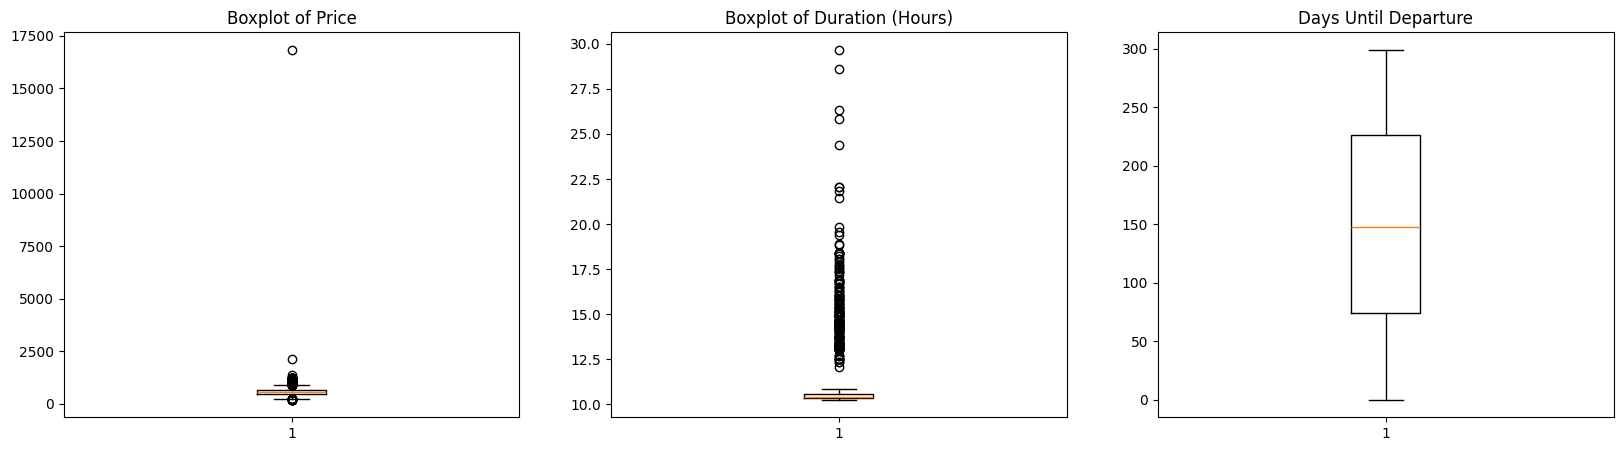

In [14]:
# We create a boxplot to visualize if there any outliers in the numeric variables.
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].boxplot(train_df["Price"])
axs[0].set_title("Boxplot of Price")
axs[1].boxplot(train_df["Duration (Hours)"])
axs[1].set_title("Boxplot of Duration (Hours)")
axs[2].boxplot(train_df["Days Until Departure"])
axs[2].set_title("Days Until Departure")
plt.show()

In [15]:
# We also calculate z-scores to identify outliers in numerical variables
z_scores_price = stats.zscore(train_df["Price"])
z_scores_duration = stats.zscore(train_df["Duration (Hours)"])
z_scores_dud = stats.zscore(train_df["Days Until Departure"])
threshold = 3 
outliers_price = train_df["Price"][abs(z_scores_price) > threshold]
outliers_duration = train_df["Duration (Hours)"][abs(z_scores_duration) > threshold]
outliers_dud = train_df["Days Until Departure"][abs(z_scores_dud) > threshold]


print("Outliers in Price:", outliers_price)
print("Outliers in Duration:", outliers_duration)
print("Outliers in Days Until Departure:", outliers_dud)

Outliers in Price: 2155    16838.0
2154     2127.0
Name: Price, dtype: float64
Outliers in Duration: 444     16.25
399     16.50
308     17.50
1865    19.83
668     17.67
2152    19.58
2478    18.08
2155    22.08
306     18.22
2276    22.08
2447    16.75
468     17.33
475     17.42
726     26.33
345     17.33
724     16.67
347     17.58
2237    17.92
473     17.17
2279    21.42
1868    19.42
725     25.83
1661    28.58
1867    18.83
446     17.75
346     16.50
1864    18.92
392     16.92
584     16.08
721     16.08
2277    18.42
305     16.33
396     16.83
398     24.38
285     29.67
2239    18.42
461     16.92
2107    21.83
2275    18.08
378     16.50
443     16.08
2467    18.42
464     16.83
665     16.25
290     16.33
1968    16.75
557     16.92
2468    18.33
2154    18.42
Name: Duration (Hours), dtype: float64
Outliers in Days Until Departure: Series([], Name: Days Until Departure, dtype: int64)


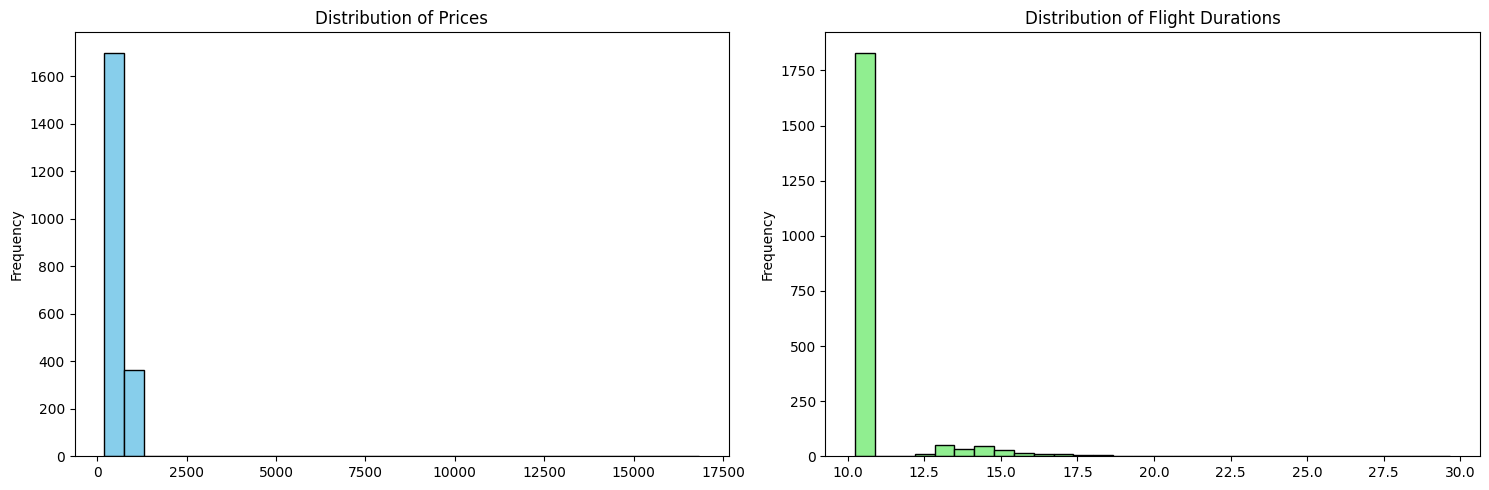

In [16]:
# We create 3 plots of our numeric variables to look at their distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histograms for each column
train_df['Price'].plot.hist(ax=axes[0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Prices')

train_df['Duration (Hours)'].plot.hist(ax=axes[1], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Flight Durations')

plt.tight_layout()
plt.show()

### **Categorical variables**

In [17]:
# Showing the distribution of each levels in the categorical variables in the dataframe
for column in train_df.select_dtypes(include='category').columns:
    print(f"Distribution for {column}:\n{train_df[column].value_counts()}\n")

Distribution for Airline:
Airline
British Airways                561
Virgin Atlantic                340
Delta                          251
Iberia                         251
Alaska Airlines                107
Norse Atlantic Airways (UK)     96
American Airlines               93
United                          80
Norse Atlantic Airways          57
Finnair                         48
Lufthansa                       47
jetBlue                         25
WestJet                         23
SWISS                           22
French Bee                      17
Aer Lingus                      16
Condor                          11
Air France                       7
Turkish Airlines                 3
LOT                              2
KLM                              2
ITA Airways                      2
LEVEL                            2
Scandinavian Airlines            1
Spirit Airlines                  1
Air Caraibes                     0
Name: count, dtype: int64

Distribution for Departure Ti

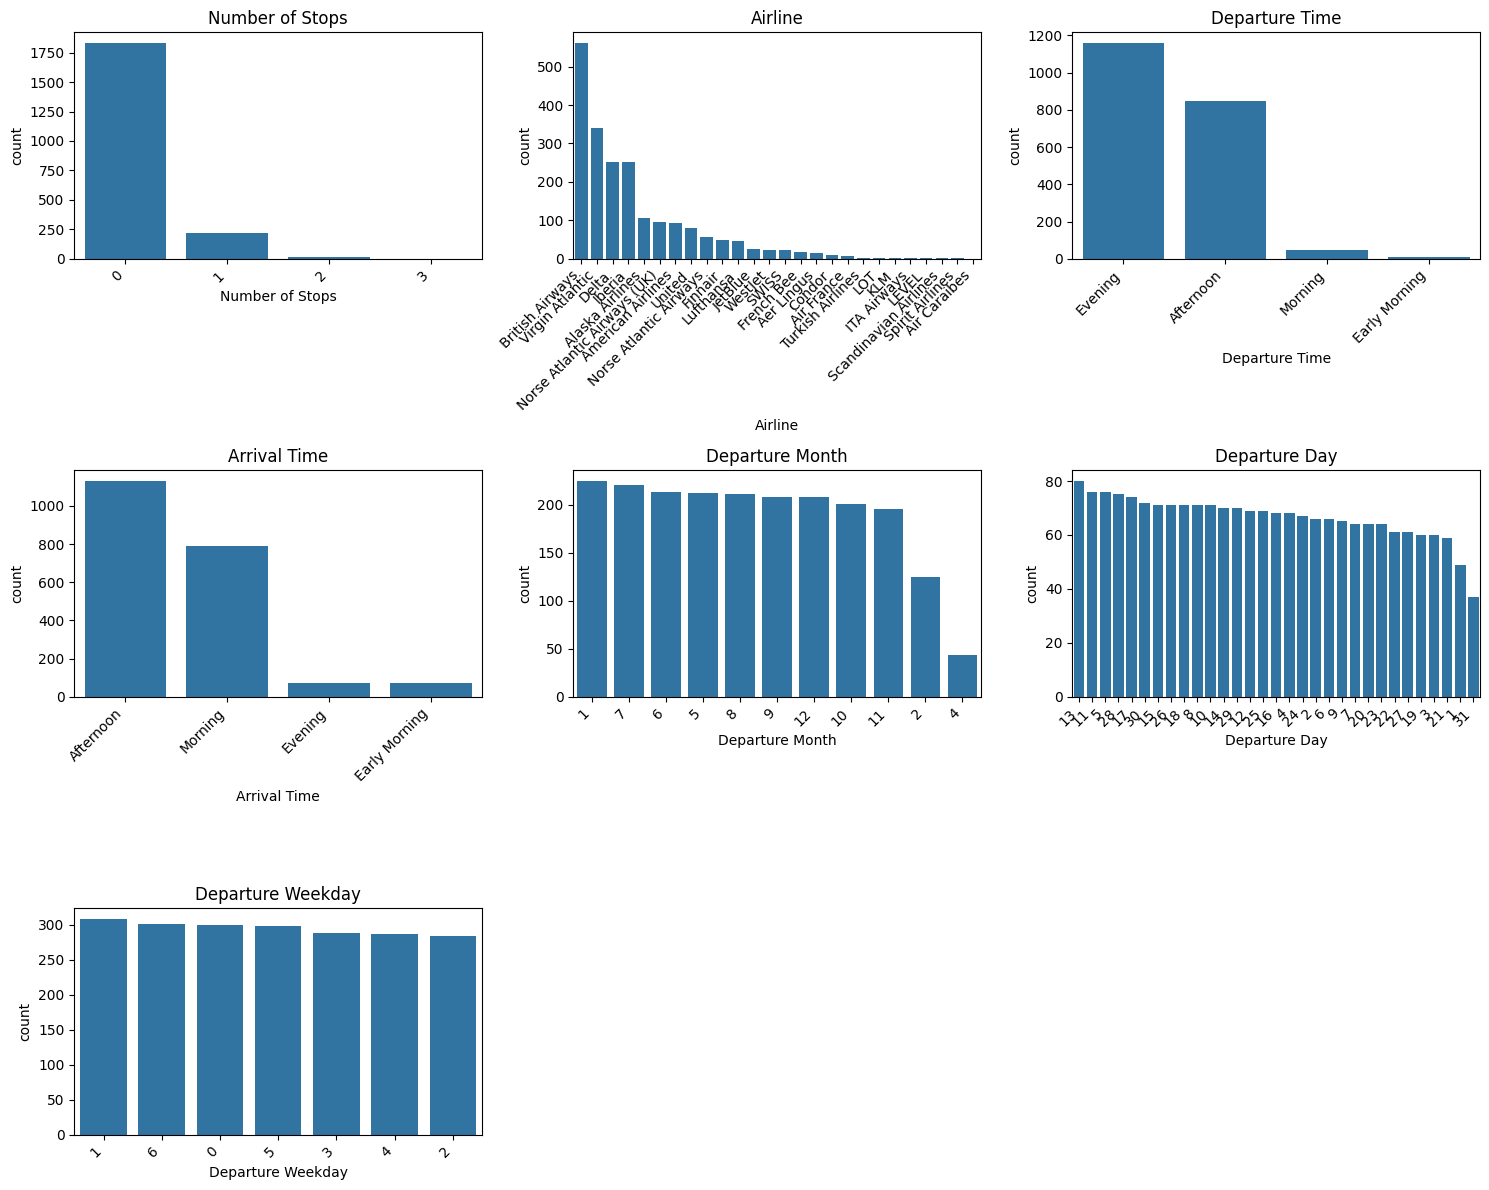

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and has been previously defined

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid of plots

# Plotting of 'Number of Stops' value counts sorted in ascending order
stops_counts = train_df['Number of Stops'].value_counts().sort_index()
sns.countplot(x='Number of Stops', data=train_df, order=stops_counts.index, ax=axes[0, 0])
axes[0, 0].set_title('Number of Stops')

# Plotting of 'Airline' value counts sorted in ascending order
airline_counts = train_df['Airline'].value_counts().sort_values(ascending=False)
sns.countplot(x='Airline', data=train_df, order=airline_counts.index, ax=axes[0, 1])
axes[0, 1].set_title('Airline')

# Plotting of 'Departure Time' value counts sorted in ascending order
departure_time_counts = train_df['Departure Time'].value_counts().sort_values(ascending=False)
sns.countplot(x='Departure Time', data=train_df, order=departure_time_counts.index, ax=axes[0, 2])
axes[0, 2].set_title('Departure Time')

# Plotting of 'Arrival Time' value counts sorted in ascending order
arrival_time_counts = train_df['Arrival Time'].value_counts().sort_values(ascending=False)
sns.countplot(x='Arrival Time', data=train_df, order=arrival_time_counts.index, ax=axes[1, 0])
axes[1, 0].set_title('Arrival Time')

# Plotting of 'Departure Month' value counts sorted in ascending order
departure_month_counts = train_df['Departure Month'].value_counts().sort_values(ascending=False)
sns.countplot(x='Departure Month', data=train_df, order=departure_month_counts.index, ax=axes[1, 1])
axes[1, 1].set_title('Departure Month')

# Plotting of 'Departure Day' value counts sorted in ascending order
departure_day_counts = train_df['Departure Day'].value_counts().sort_values(ascending=False)
sns.countplot(x='Departure Day', data=train_df, order=departure_day_counts.index, ax=axes[1, 2])
axes[1, 2].set_title('Departure Day')

# Plotting of 'Departure Weekday' value counts sorted in ascending order
departure_weekday_counts = train_df['Departure Weekday'].value_counts().sort_values(ascending=False)
sns.countplot(x='Departure Weekday', data=train_df, order=departure_weekday_counts.index, ax=axes[2, 0])
axes[2, 0].set_title('Departure Weekday')

# Removing the last to axis that are not in use
axes[2, 1].set_visible(False)  # Hide this axis if not in use
axes[2, 2].set_visible(False)  # Hide this axis if not in use

# Rotating the labels on the x-axis to prevent overlap
for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()


## **Target Engineering**

In [19]:
# The threshold is set to 3 as in the EDA 

# Filter the dataframe to remove outliers in price
train_df = train_df[abs(z_scores_price) <= threshold]

# If you want to remove outliers for both variables at the same time
train_df = train_df[(abs(z_scores_price) <= threshold)]

/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_2123/1838671461.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[(abs(z_scores_price) <= threshold)]


In [54]:
train_df.describe()

,Price,Days Until Departure,Duration (Hours)
count,2063.000000,2063.000000,2063.000000
mean,605.675230,149.051381,10.944658
std,178.009675,87.142187,1.683834
min,196.000000,0.000000,10.250000
25%,488.000000,74.000000,10.330000
50%,588.000000,148.000000,10.420000
75%,658.000000,226.000000,10.580000
max,1357.000000,299.000000,29.670000


In [20]:
# We also calculate z-scores to identify outliers in numerical variables
z_scores_price = stats.zscore(test_df["Price"])

# Filter the dataframe to remove outliers in price
test_df = test_df[abs(z_scores_price) <= threshold]

# If you want to remove outliers for both variables at the same time
test_df = test_df[(abs(z_scores_price) <= threshold)]

/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_2123/4072614553.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = test_df[(abs(z_scores_price) <= threshold)]


## **Feature Engineering**

In [21]:
# Calculate the percentage of each category
airline_counts = train_df['Airline'].value_counts(normalize=True)

# Find categories with less than 10% of the observations
small_categories = airline_counts[airline_counts < 0.10].index

# Lump small categories into "Other Airlines"
train_df['Airline'] = train_df['Airline'].apply(lambda x: "Other Airlines" if x in small_categories else x)

# Check the modified 'Airline' column
train_df['Airline'].value_counts(normalize=True)


Airline
Other Airlines     0.319922
British Airways    0.271934
Virgin Atlantic    0.164809
Delta              0.121667
Iberia             0.121667
Name: proportion, dtype: float64

In [22]:
airline_counts = test_df['Airline'].value_counts(normalize=True)

# Find categories with less than 10% of the observations
small_categories = airline_counts[airline_counts < 0.10].index

# Lump small categories into "Other Airlines"
test_df['Airline'] = test_df['Airline'].apply(lambda x: "Other Airlines" if x in small_categories else x)

# Check the modified 'Airline' column
test_df['Airline'].value_counts(normalize=True)

Airline
British Airways    0.296424
Other Airlines     0.272203
Virgin Atlantic    0.164937
Delta              0.144175
Iberia             0.122261
Name: proportion, dtype: float64

In [23]:
# One-hot encoding categorical variables
# creates dummies in format boolean and deleted first to avoid multicollinearity
categorical_columns = ['Airline', 'Departure Time', 'Arrival Time', 'Departure Month', 'Departure Day', 'Departure Weekday']
data_encoded_train = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
data_encoded_test = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)

In [24]:
# Splitting the data into features and target variable
X_train = data_encoded_train.drop('Price', axis=1)
y_train = data_encoded_train['Price']

X_test = data_encoded_test.drop('Price', axis=1)
y_test = data_encoded_test['Price']

## **Linear Regression**

In [25]:
# In order for the regression to work, we need to convert the dummy variables into integers
categorical_columns_lm = data_encoded_train.astype(int)

# Here we define our targets and features
X_train_lm = pd.concat([categorical_columns_lm, train_df[['Days Until Departure', 'Duration (Hours)']]], axis=1) # Features
X_train_lm = X_train_lm.drop('Price', axis=1)
y_train_lm = train_df['Price']  # Target variable

# Doing the same for the test set
categorical_columns_lm_test = data_encoded_test.astype(int)

# Defining target and features
X_test_lm = pd.concat([categorical_columns_lm_test, test_df[['Days Until Departure', 'Duration (Hours)']]], axis=1) # Features
X_test_lm = X_test_lm.drop('Price', axis=1)
y_test_lm = test_df['Price']  # Target variable

X_test_lm = sm.add_constant(X_test_lm) # Adding betas

In [26]:
# Calculating beta coefficients for the features
X_train_lm = sm.add_constant(X_train_lm)

# Creating the model
model_lm = sm.OLS(y_train_lm, X_train_lm).fit()
print(model_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     26.59
Date:                Wed, 15 May 2024   Prob (F-statistic):          5.79e-207
Time:                        10:15:08   Log-Likelihood:                -13020.
No. Observations:                2063   AIC:                         2.616e+04
Df Residuals:                    2003   BIC:                         2.650e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [27]:
# Predicting and evealuting the training error
y_train_pred_lm = model_lm.predict(X_train_lm)
lm_train_rmse = np.sqrt(mean_squared_error(y_train_lm, y_train_pred_lm))
print("Linear Regression Train RMSE:", lm_train_rmse)

# Predicting and evealuting the test error
y_test_pred_lm = model_lm.predict(X_test_lm)
lm_test_rmse = np.sqrt(mean_squared_error(y_test_lm, y_test_pred_lm))
print("Linear Regression Test RMSE:", lm_test_rmse)

Linear Regression Train RMSE: 133.2752275311388
Linear Regression Test RMSE: 121.01046986973215


## **KNN**

In [28]:
# Train the model
knn_model = KNeighborsRegressor(n_neighbors=5)  # Chooses k=5 neighbours
knn_model.fit(X_train, y_train) # Fits the model to the train data

# Prediciting and evaluating training error
y_train_pred_knn = knn_model.predict(X_train)
knn_train_rmse = mean_squared_error(y_train, y_train_pred_knn, squared=False) 
print(f"KNN Train RMSE: {knn_train_rmse}")

# Predicting and evaluating test error
y_test_pred_knn = knn_model.predict(X_test) # Predicts the price for the test set
knn_test_rmse = mean_squared_error(y_test, y_test_pred_knn, squared=False) 
print(f"KNN Test RMSE: {knn_test_rmse}")

KNN Train RMSE: 87.98327761618825
KNN Test RMSE: 97.48667717214951


/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## **Decision Tree**

In [29]:
# Intializing and fitting Decision Tree Regressor
dtr_model = DecisionTreeRegressor(random_state=123)
dtr_model.fit(X_train, y_train)

# Predicting and evaluating the test error
y_train_pred_dtr = dtr_model.predict(X_train)
dtr_train_rmse = mean_squared_error(y_train, y_train_pred_dtr, squared=False)
print(f"Decision Tree Train RMSE: {dtr_train_rmse}")

# Prediciting and evaluating the test error
y_test_pred_dtr = dtr_model.predict(X_test)
dtr_test_rmse = mean_squared_error(y_test, y_test_pred_dtr, squared=False)
print(f"Decision Tree Test RMSE: {dtr_test_rmse}")

Decision Tree Train RMSE: 16.780867430330648
Decision Tree Test RMSE: 72.18614601879844


/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## **Random Forest**

In [30]:
# Initializing and fitting the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(X_train, y_train)

# Predicting and evaluating the training error
y_train_pred_rf = rf_model.predict(X_train)
rf_train_rmse = mean_squared_error(y_train, y_train_pred_rf, squared=False)
print(f"Root Mean Squared Error: {rf_train_rmse}")

# Predict and evaluate the model
y_test_pred_rf = rf_model.predict(X_test)
rf_test_rmse = mean_squared_error(y_test, y_test_pred_rf, squared=False)
print(f"Root Mean Squared Error: {rf_test_rmse}")

Root Mean Squared Error: 26.676648543088653
Root Mean Squared Error: 51.739053177097865


/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
# After choosing the performing model, we will now do Hyperparameter tuning in order to see if we can tune the parameters to obtain and even better result

# Creating parameter grid in order to test different parameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initializing GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score (converted to positive as scoring is negative MSE)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)

# Using best estimator to make predictions
best_rf = grid_search.best_estimator_
y_train_pred_best_rf = best_rf.predict(X_train)
y_test_pred_best_rf = best_rf.predict(X_test)

# Evaluating the best model on training data
rmse_train_best_rf = mean_squared_error(y_train, y_train_pred_best_rf, squared=False)
print(f"Training Root Mean Squared Error: {rmse_train_best_rf}")

# Evaluating the best model on test data
rmse_test_best_rf = mean_squared_error(y_test, y_test_pred_best_rf, squared=False)
print(f"Root Mean Squared Error: {rmse_test_best_rf}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.3s
[CV] END m

/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/katrinekjaergaard/OneDrive - Aarhus Universitet/Kandidat/8. semester/Data Science Project/Python/dsp-flight/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
from sklearn.metrics import r2_score
# Calculating R-squared for training data
r2_train_best_rf = r2_score(y_train, y_train_pred_best_rf)
print(f"Training R-squared: {r2_train_best_rf}")

# Calculating R-squared for test data
r2_test_best_rf = r2_score(y_test, y_test_pred_best_rf)
print(f"Test R-squared: {r2_test_best_rf}")

Training R-squared: 0.9772070091892988
Test R-squared: 0.8896378049929319


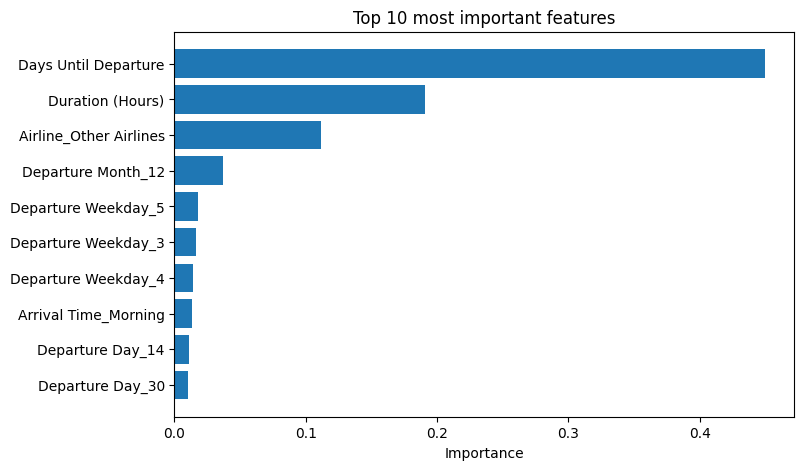

In [49]:
# Extracting feature importances from the Random Forest Regression
importances = best_rf.feature_importances_
feature_names = X_train.columns  

# Sorting feature importances in descending order for better visualization
indices = np.argsort(importances)[::-1]

# Plotting the feature importances in a vertical bar chart
plt.figure(figsize=(8, 5)) 
plt.title("Top 10 most important features")
plt.barh(range(len(indices[:10])), importances[indices][:10], align='center')  
plt.yticks(range(len(indices[:10])), feature_names[indices][:10]) 
plt.xlabel('Importance')
plt.gca().invert_yaxis() 
plt.show()


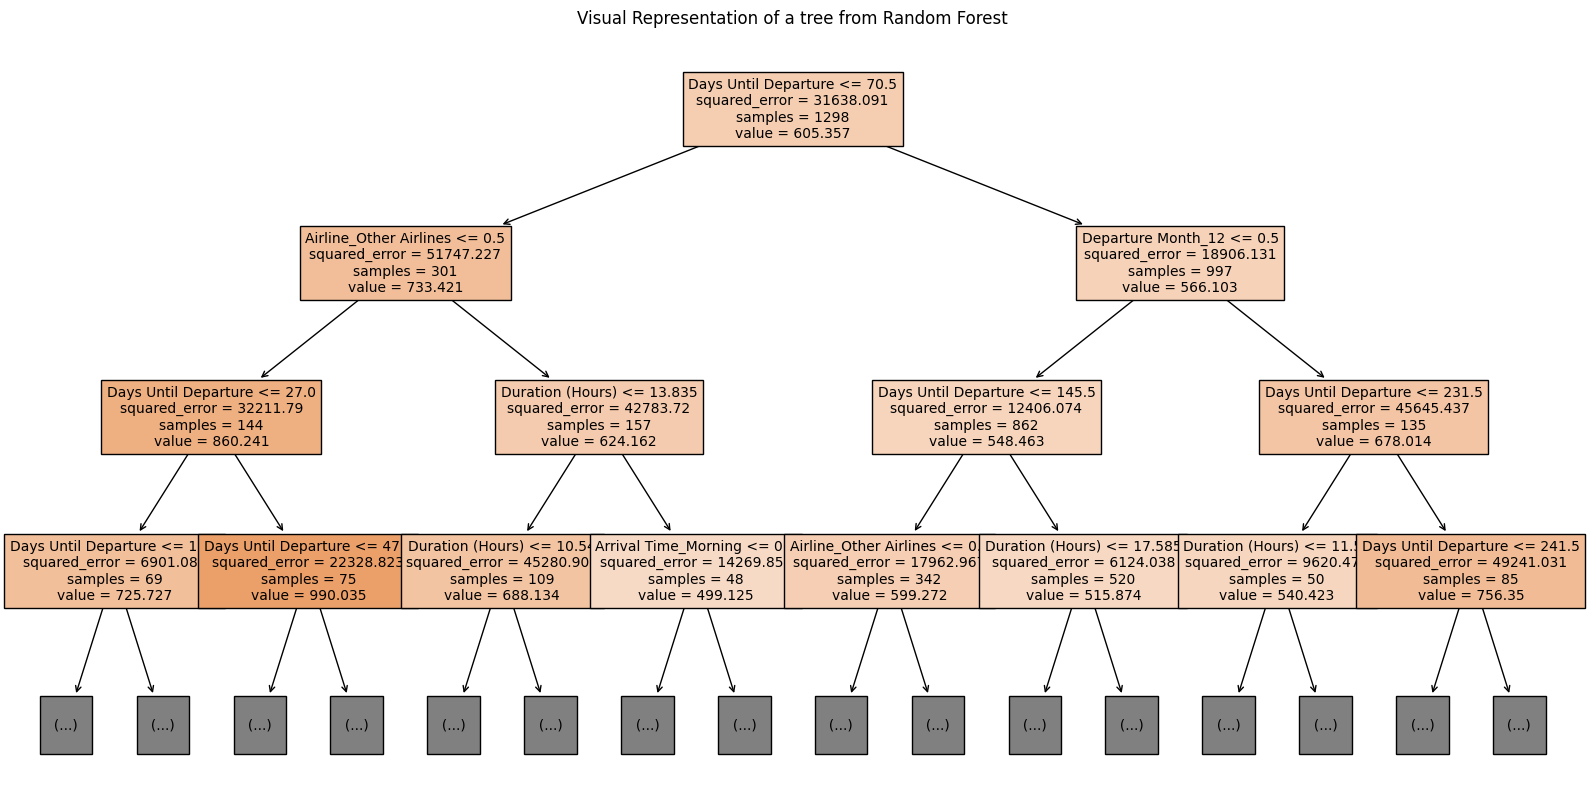

In [69]:
#Visualize tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

#Select one tree from the random forest
tree = best_rf.estimators_[75]

# Visualize the selected tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=X_test.columns, max_depth=3, fontsize=10)
plt.title('Visual Representation of a tree from Random Forest')
plt.show()